# Prompt

Using a dataset of your own, explore the data utilizing multiple cross-validation techniques. Choose the most appropriate cross-validation technique for your data.

In your initial post, describe your data, state which cross-validation technique you used, and explain your rationale for deciding on which cross-validation technique was the most appropriate for your specific dataset.

# Problem Statement

Using a diabetes data set, make BMI the target feature. I realize the objective of this data set is predicting diabetes, not BMI, but I was interested in a numeric, not categorical feature, so I somewhat arbitrarily decided to check if I could predict BMI given the other features.

# Imports

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.utils import shuffle
from sklearn.feature_selection import SequentialFeatureSelector
import plotly.express as px

np.random.seed(1234)

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [230]:
df = pd.read_csv("./data/diabetes.csv").drop(columns="Outcome")
display(df.head())
display(df.info())
df.dropna(inplace=True)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


None

# Drop Outliers

In [239]:
features_with_zero_as_null = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
]

for feature in features_with_zero_as_null:
    df = df.query(feature + ">0")

df = df.query("BMI < 50")

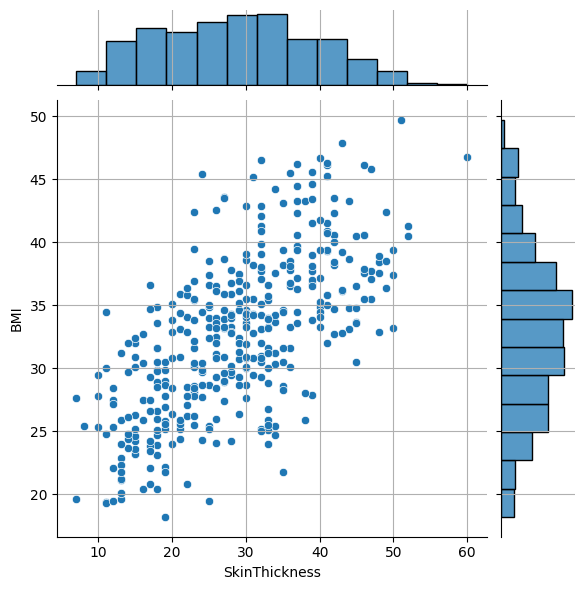

In [232]:
sns.jointplot(df, x="SkinThickness", y="BMI")

In [128]:
# px.scatter(
#     df,
#     x="SkinThickness",
#     y="BMI",
#     trendline="ols",
#     trendline_color_override="red",
# )

In [233]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,3.341969,122.339378,70.507772,28.886010,155.209845,32.708549,0.517443,30.963731
std,3.216379,30.768281,12.117228,10.300799,116.364095,6.358559,0.333518,10.247013
min,0.000000,56.000000,24.000000,7.000000,15.000000,18.200000,0.085000,21.000000
25%,1.000000,99.000000,62.000000,21.000000,76.250000,28.325000,0.269000,23.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.100000,0.446500,27.000000
75%,5.000000,143.000000,78.000000,36.000000,190.000000,36.875000,0.681000,36.000000
max,17.000000,198.000000,110.000000,60.000000,846.000000,49.700000,2.329000,81.000000


# Model Setup

Etablish a pipeline of:
- Polynomial features
- Standardization
- Ridge Regression

and declare the hyperparameter of interest to be the alpha parameter for ridge.

We also saw that polynomial performance (more so on higher-order models) suffered unless the data was scaled prior to doing the polynomial feature transformation, so we will scale the data up front once.

### Defining Features

In [ ]:
target_feature = "BMI"

In [234]:
numeric_features = df.columns[df.dtypes != "object"].to_list()
numeric_features.remove(target_feature)
numeric_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'DiabetesPedigreeFunction',
 'Age']

### Standardize

Before the poly xformer, to avoid forming higher-order terms from large values

In [235]:
df_zscores = df.copy(deep=True)
df_zscores[numeric_features] = StandardScaler().fit_transform(df[numeric_features])
df_zscores.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
3,-0.729083,-1.084970,-0.372496,-0.572155,-0.526703,28.1,-1.052109,-0.973617
4,-1.040396,0.477103,-2.520986,0.594316,0.110058,43.1,5.315613,0.198976
6,-0.106459,-1.442945,-1.694644,0.302698,-0.578332,31.0,-0.808929,-0.485036
8,-0.417771,2.429694,-0.041959,1.566374,3.336884,30.5,-1.079129,2.153298
13,-0.729083,2.169349,-0.868302,-0.572155,5.944159,30.1,-0.358595,2.739594


In [236]:
df_zscores.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,3.860000e+02,3.860000e+02,3.860000e+02,3.860000e+02,3.860000e+02,386.000000,3.860000e+02,3.860000e+02
mean,4.601961e-17,1.484132e-16,4.256814e-16,2.761176e-17,2.070882e-17,32.708549,1.104471e-16,1.840784e-17
std,1.001298e+00,1.001298e+00,1.001298e+00,1.001298e+00,1.001298e+00,6.358559,1.001298e+00,1.001298e+00
min,-1.040396e+00,-2.158895e+00,-3.843134e+00,-2.127448e+00,-1.206487e+00,18.200000,-1.298292e+00,-9.736166e-01
25%,-7.290835e-01,-7.595377e-01,-7.030332e-01,-7.665663e-01,-6.794392e-01,28.325000,-7.458821e-01,-7.781845e-01
50%,-4.177713e-01,-1.086740e-01,-4.195935e-02,1.108046e-02,-2.556493e-01,33.100000,-2.129870e-01,-3.873202e-01
75%,5.161653e-01,6.723624e-01,6.191145e-01,6.915214e-01,2.993647e-01,36.875000,4.910351e-01,4.921245e-01
max,4.251912e+00,2.462238e+00,3.263410e+00,3.024462e+00,5.944159e+00,49.700000,5.438704e+00,4.889348e+00


### Build Pipeline

In [139]:
estimator = Pipeline(
    [
        ("transform", PolynomialFeatures(degree=2, include_bias=False)),
        ("scale", StandardScaler()),
        ("regression", Ridge()),
    ]
)

# Cross Validation Common Setup

## Specify Hyperparameter Search Space

In [238]:
alpha_list = 10 ** np.linspace(-5, 5, 51)
param_grid = {"regression__alpha": alpha_list}

## Results Plotter Function

In [240]:
def score_plot(grid_object):
    best_alpha = grid_object.best_params_["regression__alpha"]
    best_score = -grid_object.cv_results_["mean_test_score"][alpha_list == best_alpha]

    plt.plot(
        1.0 / alpha_list,
        -grid_object.cv_results_["mean_test_score"],
        label="Dev",
    )
    plt.xscale("log")
    plt.axvline(
        x=1.0 / best_alpha,
        color="cyan",
        label="Alpha for Best Score = %.2f" % best_alpha,
    )
    plt.axhline(
        y=best_score,
        color="maroon",
        label="Best Dev Score = %.2f" % best_score,
    )

    plt.xlabel("1/Alpha")
    plt.ylabel("Negative of Mean Test Score")
    plt.legend()

# Cross Validation with Holdout

### Get Training and Development Indices

In [237]:
all_inds = shuffle(range(len(df_zscores)), random_state=42)
(train_inds, dev_inds) = np.split(all_inds, [int(0.7 * len(df_zscores))])
display([train_inds[:10], dev_inds[:10]])

[array([336, 307,  90, 265, 150, 297,  78, 101, 312,  33]),
 array([256, 356, 100, 226, 329, 213, 171,  98, 215,  61])]

### Perform the Gridded Search

In [229]:
grid_search_holdout = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(df_zscores[numeric_features], df_zscores[target_feature])

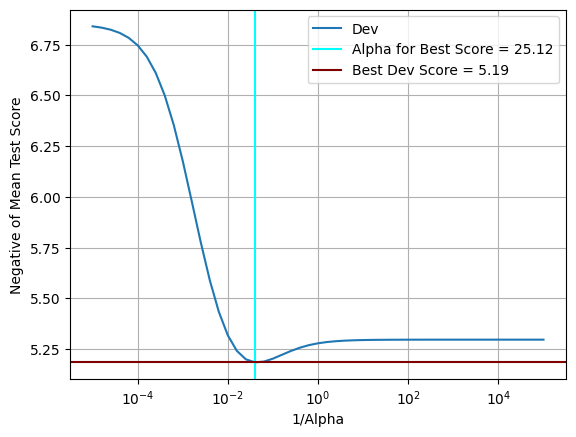

In [241]:
score_plot(grid_search_holdout)

# Cross Validation with K-Fold

In [150]:
grid_search_kfold = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=10,
).fit(df_zscores[numeric_features], df_zscores[target_feature])

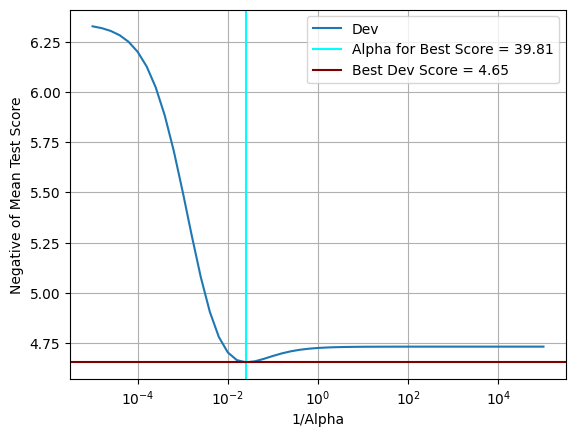

In [242]:
score_plot(grid_search_kfold)

# Cross Validation with Leave One Out

In [154]:
grid_search_loo = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=len(df_zscores),
).fit(df_zscores[numeric_features], df_zscores[target_feature])

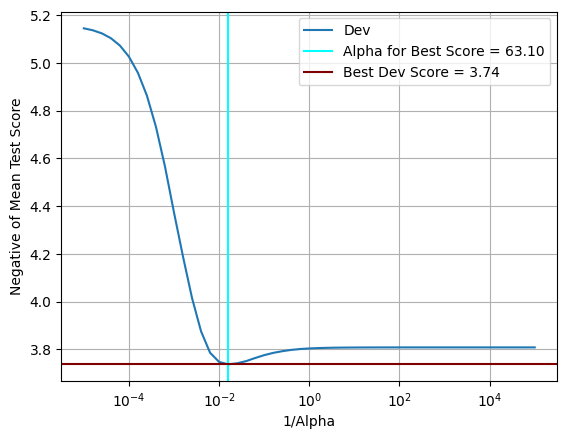

In [243]:
score_plot(grid_search_loo)

# Comparisons and Conclusions

Text(0, 0.5, 'Negative of Mean Test Score')

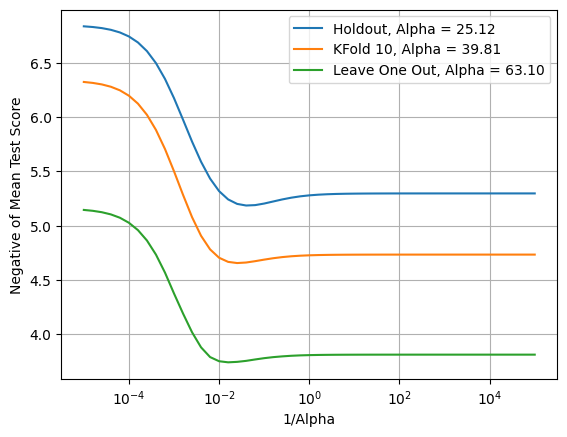

In [246]:
def plot_score_vs_alpha(grid_object, label):
    best_alpha = grid_object.best_params_["regression__alpha"]
    y = -grid_object.cv_results_["mean_test_score"]
    plt.plot(
        1.0 / alpha_list,
        y,
        label="%s, Alpha = %.2f" % (label, best_alpha),
    )


plot_score_vs_alpha(grid_search_holdout, "Holdout")
plot_score_vs_alpha(grid_search_kfold, "KFold 10")
plot_score_vs_alpha(grid_search_loo, "Leave One Out")

plt.xscale("log")
plt.legend()
plt.xlabel("1/Alpha")
plt.ylabel("Negative of Mean Test Score")